<a href="https://colab.research.google.com/github/krteja44/Deep_Learning_with_PyTorch/blob/master/convolutional-neural-networks/cifar-cnn/CIFAR10_CNN_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available, Train on CPU..')
else:
  print('CUDA is available, Train on GPU..')

CUDA is available, Train on GPU..


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2


transform = transforms.Compose([
           transforms.RandomHorizontalFlip(),
           transforms.RandomRotation(10),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
           ])


train_data = datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_data = datasets.CIFAR10(root='data', download=True, train=False, transform=transform)

num_train=len(train_data)
indices = list(range(num_train))
numpy.random.shuffle(indices)
split = int(numpy.floor(valid_size * num_train))
train_idx = indices[split:] 
valid_idx = indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(numpy.transpose(img, (1, 2, 0)))

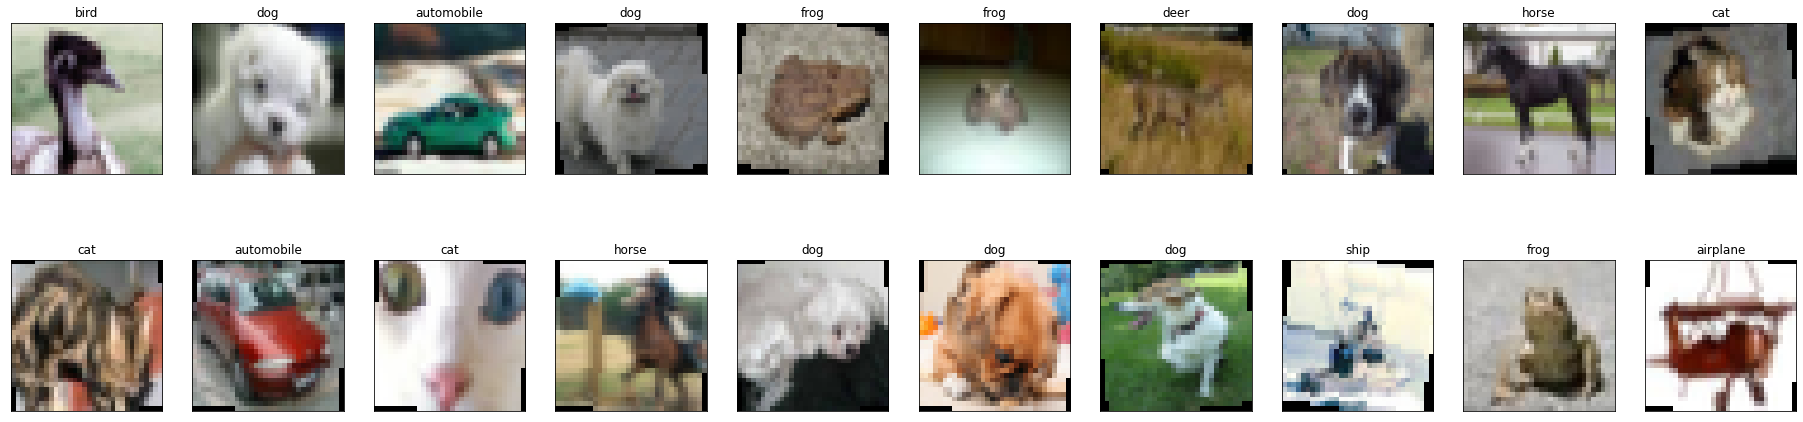

In [5]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize = (32, 8))
for i in range(len(images)):
  ax = fig.add_subplot(2, len(images)/2, i+1, xticks=[], yticks=[])
  imshow(images[i])
  ax.set_title(classes[labels[i]])

In [6]:
labels

tensor([2, 5, 1, 5, 6, 6, 4, 5, 7, 3, 3, 1, 3, 7, 5, 5, 5, 8, 6, 0])

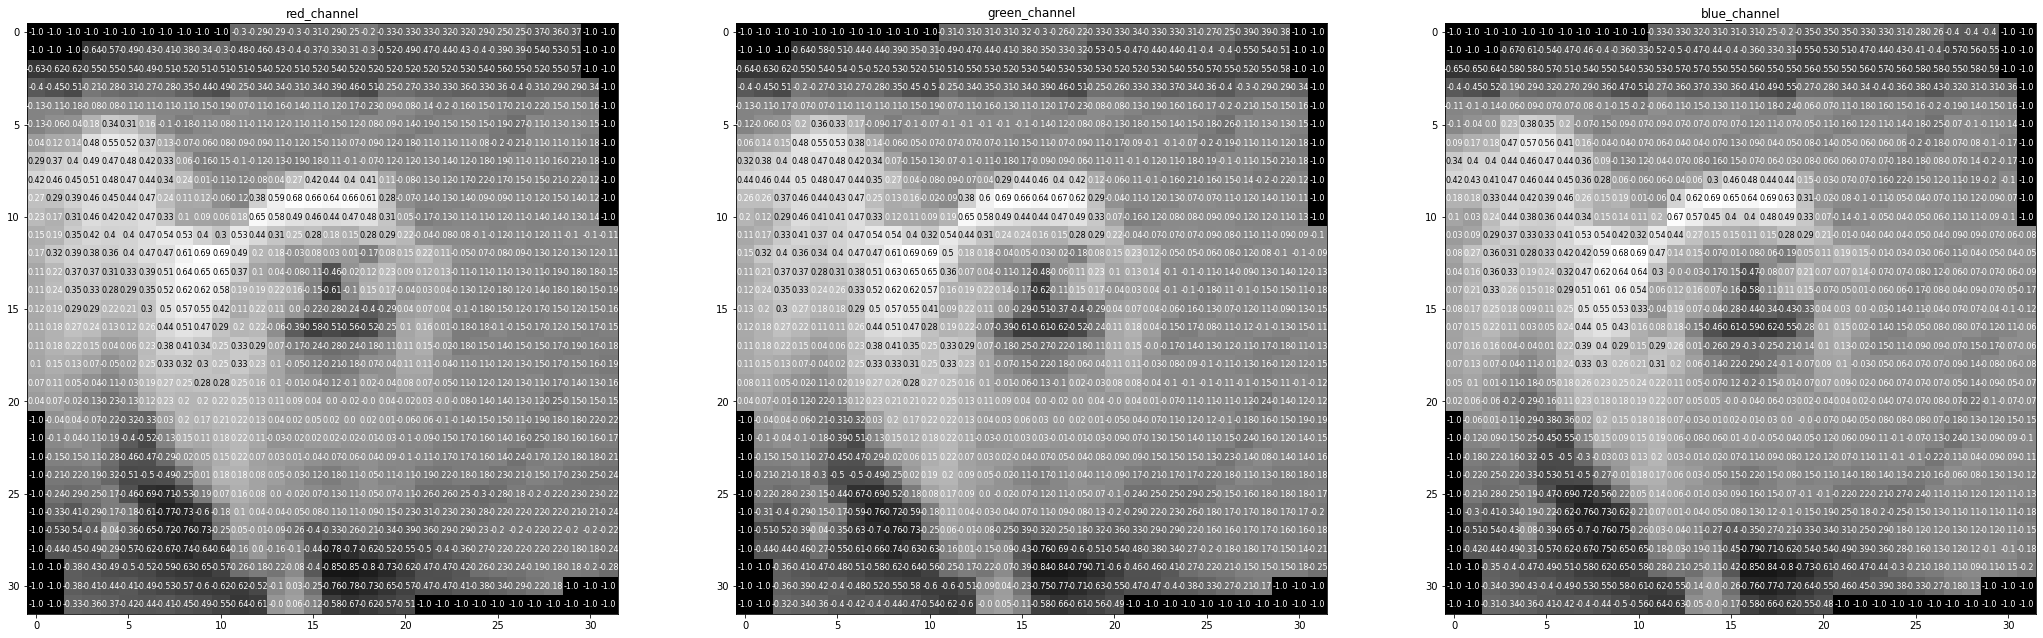

In [7]:
rgb_img = numpy.squeeze(images[3])
channels = ['red_channel', 'green_channel', 'blue_channel']

fig = plt.figure(figsize = (36,36))
for idx in numpy.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx+1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
                  horizontalalignment='center',
                  verticalalignment='center', size=8,
                  color='white' if img[x][y]<thresh else 'black')

In [8]:
import torch.nn as nn
from torch.nn import functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
    # convolutional layer (sees 16x16x16 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    # convolutional layer (sees 8x8x32 image tensor)
    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    # convolutional layer (sees 4x4x64 image tensor)
    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128*2*2, 500)
    self.fc2 = nn.Linear(500, 10)
    
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = x.view(-1, 128*2*2)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

model = Net()
print(model)

if train_on_gpu:
  model.cuda()
    


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
from torch import optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.02)

In [24]:
valid_loss_min = numpy.Inf

n_epochs = 30

for epoch in range(n_epochs):

  train_loss = 0.0
  valid_loss = 0.0

  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

  model.eval()
  for data, target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

  if valid_loss <= valid_loss_min:
    print('Valid Loss Decreased ({:.6f} --->  {:.6f}). Saving Model...'.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_with_augmentation.pt')
    valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 0.449314 	Validation Loss: 0.744118
Valid Loss Decreased (inf --->  0.744118). Saving Model...
Epoch: 2 	 Training Loss: 0.445779 	Validation Loss: 0.761188
Epoch: 3 	 Training Loss: 0.433223 	Validation Loss: 0.747476
Epoch: 4 	 Training Loss: 0.429994 	Validation Loss: 0.716999
Valid Loss Decreased (0.744118 --->  0.716999). Saving Model...
Epoch: 5 	 Training Loss: 0.424370 	Validation Loss: 0.750274
Epoch: 6 	 Training Loss: 0.413405 	Validation Loss: 0.724844
Epoch: 7 	 Training Loss: 0.408963 	Validation Loss: 0.713977
Valid Loss Decreased (0.716999 --->  0.713977). Saving Model...
Epoch: 8 	 Training Loss: 0.410595 	Validation Loss: 0.729481
Epoch: 9 	 Training Loss: 0.397579 	Validation Loss: 0.745971
Epoch: 10 	 Training Loss: 0.394637 	Validation Loss: 0.755389
Epoch: 11 	 Training Loss: 0.388189 	Validation Loss: 0.766300
Epoch: 12 	 Training Loss: 0.385080 	Validation Loss: 0.770300
Epoch: 13 	 Training Loss: 0.380054 	Validation Loss: 0.731511
Epo

In [25]:
for batch_idx, (data, target) in enumerate(train_loader):
  print(images.shape)
  break

torch.Size([20, 3, 32, 32])


In [26]:
model.load_state_dict(torch.load('/content/model_with_augmentation.pt'))

<All keys matched successfully>

In [27]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

  ouput = model(data)
  loss= criterion(output, target)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = numpy.squeeze(correct_tensor.numpy()) if not train_on_gpu else numpy.squeeze(correct_tensor.cpu().numpy())

  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            numpy.sum(class_correct[i]), numpy.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * numpy.sum(class_correct) / numpy.sum(class_total),
    numpy.sum(class_correct), numpy.sum(class_total)))


Test Loss: 14.120112

Test Accuracy of airplane: 10% (104/1000)
Test Accuracy of automobile: 14% (141/1000)
Test Accuracy of  bird:  5% (50/1000)
Test Accuracy of   cat: 21% (218/1000)
Test Accuracy of  deer:  5% (53/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  4% (41/1000)
Test Accuracy of horse:  5% (54/1000)
Test Accuracy of  ship: 25% (257/1000)
Test Accuracy of truck:  9% (98/1000)

Test Accuracy (Overall): 10% (1016/10000)


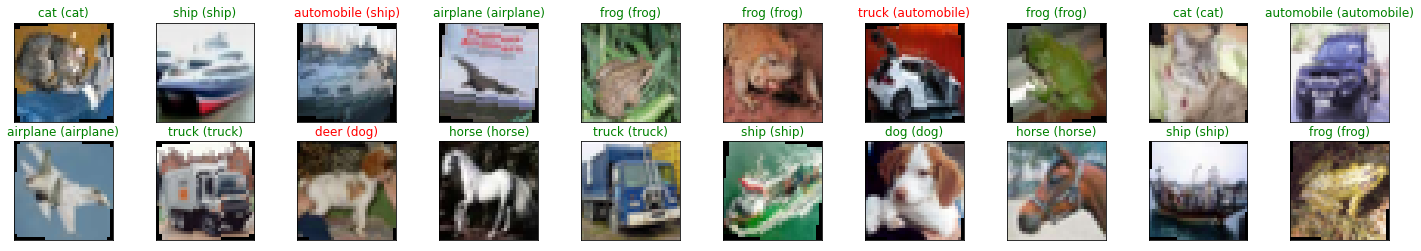

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = numpy.squeeze(preds_tensor.numpy()) if not train_on_gpu else numpy.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in numpy.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [28]:
import torch.nn as nn
from torch.nn import functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # convolutional layer (sees 16x16x16 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # convolutional layer (sees 8x8x32 image tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    # convolutional layer (sees 4x4x64 image tensor)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128*2*2, 500)
    self.fc2 = nn.Linear(500, 10)
    
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = x.view(-1, 128*2*2)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

model = Net()
print(model)

if train_on_gpu:
  model.cuda()
    


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [29]:
from torch import optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [30]:
valid_loss_min = numpy.Inf

n_epochs = 30

for epoch in range(n_epochs):

  train_loss = 0.0
  valid_loss = 0.0

  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

  model.eval()
  for data, target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

  if valid_loss <= valid_loss_min:
    print('Valid Loss Decreased ({:.6f} --->  {:.6f}). Saving Model...'.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_with_augmentation_2.pt')
    valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 2.277339 	Validation Loss: 2.146647
Valid Loss Decreased (inf --->  2.146647). Saving Model...
Epoch: 2 	 Training Loss: 1.939074 	Validation Loss: 1.740530
Valid Loss Decreased (2.146647 --->  1.740530). Saving Model...
Epoch: 3 	 Training Loss: 1.633807 	Validation Loss: 1.537860
Valid Loss Decreased (1.740530 --->  1.537860). Saving Model...
Epoch: 4 	 Training Loss: 1.498220 	Validation Loss: 1.390033
Valid Loss Decreased (1.537860 --->  1.390033). Saving Model...
Epoch: 5 	 Training Loss: 1.399285 	Validation Loss: 1.328607
Valid Loss Decreased (1.390033 --->  1.328607). Saving Model...
Epoch: 6 	 Training Loss: 1.320860 	Validation Loss: 1.285074
Valid Loss Decreased (1.328607 --->  1.285074). Saving Model...
Epoch: 7 	 Training Loss: 1.249041 	Validation Loss: 1.166562
Valid Loss Decreased (1.285074 --->  1.166562). Saving Model...
Epoch: 8 	 Training Loss: 1.192908 	Validation Loss: 1.159315
Valid Loss Decreased (1.166562 --->  1.159315). Saving Model.

In [31]:
model.load_state_dict(torch.load('/content/model_with_augmentation_2.pt'))

<All keys matched successfully>

In [32]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

  ouput = model(data)
  loss= criterion(output, target)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = numpy.squeeze(correct_tensor.numpy()) if not train_on_gpu else numpy.squeeze(correct_tensor.cpu().numpy())

  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            numpy.sum(class_correct[i]), numpy.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * numpy.sum(class_correct) / numpy.sum(class_total),
    numpy.sum(class_correct), numpy.sum(class_total)))


Test Loss: 6.031936

Test Accuracy of airplane: 24% (249/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird: 10% (100/1000)
Test Accuracy of   cat:  4% (46/1000)
Test Accuracy of  deer: 18% (181/1000)
Test Accuracy of   dog:  9% (91/1000)
Test Accuracy of  frog:  5% (52/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  9% (95/1000)
Test Accuracy of truck: 14% (141/1000)

Test Accuracy (Overall):  9% (955/10000)


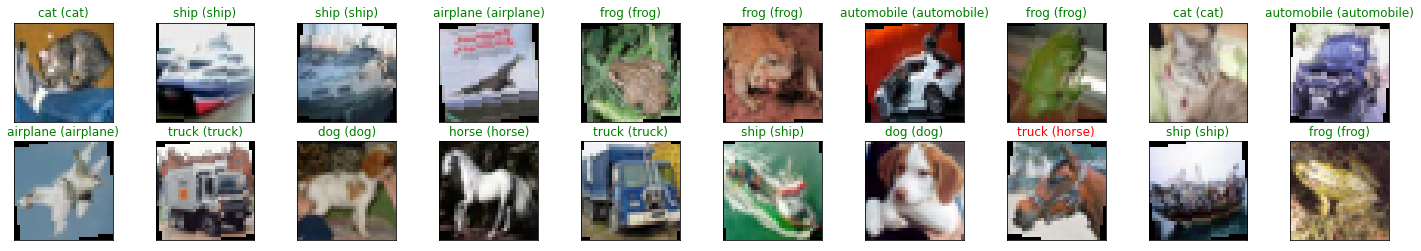

In [41]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = numpy.squeeze(preds_tensor.numpy()) if not train_on_gpu else numpy.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in numpy.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))